# Automated Molecule Generation - Making Fragment Library

> ### In this tutorial we will cover:
> - how we can generate a molecular fragment library in BuildAMol (the very low-tech way)

Many automated molecule design frameworks work with a database of potential substructures (i.e. fragments) that can be assembled to form useful compounds. BuildAMol itself is no exception to this. Remember, BuildAMol does maintain a (albeit small) built-in compounds database that can be extended by the user and queries PubChem for unknown fragment requests. 

However, what if we want to generate our own fragment library for some specific purpose? Downloading all of PubChem might be overkill in such cases. Let's examine a small toy example here. Let's say we want to generate a library of small organic molecules which might form a ligand to a protein. We want a library with fragment molecules that we can then pass to some ligand design tool to get some good candidate structures. 

In this tutorial we will do the following: 
1. define some basic fragments based on their carbon backbone architecture
2. randomly manipulate these fragments by adding in some hetero-atoms
3. save the whole thing into some useable data format

In [1]:
import buildamol as bam
import random
import matplotlib.pyplot as plt

Alrighty, let's start by making some molecules for the basic backbones that we want included in our library. We will use SMILES here since they are more straightforward than trivial names:

In [2]:
# get alkane and alkene chains from length 1 (methyl) to 5 (pentyl)
# which may serve as linkers in the molecule
simple_carbons = [
    bam.read_smiles(
        "C" * i
    )
    for i in range(1, 6)
] + [
    bam.read_smiles(
        "C" * i + "=C"
    )
    for i in range(1, 4)
]

# now get some cyclic carbons such as benzene or cyclpentane
cyclic_carbons = [
    bam.read_smiles("C1=CC=CC=C1"), 
    bam.read_smiles("C1=CC=CC1"), 
    bam.read_smiles("C1CCCCC1"), 
    bam.read_smiles("C1CCCC1"),
    bam.read_smiles("C1(C=CC2)=C2C=CC=C1"),
    bam.read_smiles("C1(CCCC2)=C2C=CC=C1"),
]

Great! Now to make the whole thing more enjoyable let's also look at the fragments we just made:

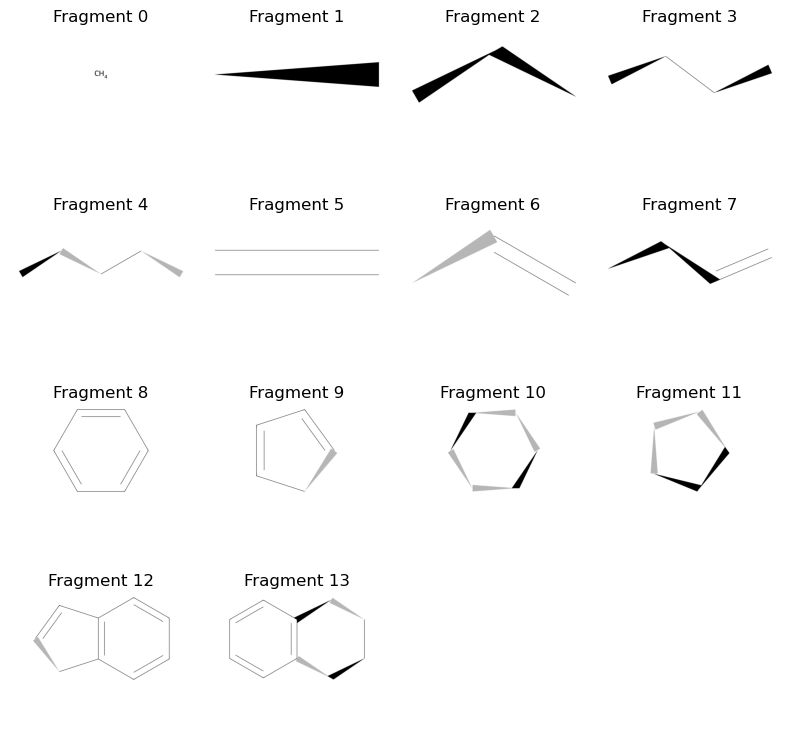

In [3]:
def visualize_fragments(fragments: list, layout: tuple, figsize=None):
    nrows, ncols = layout    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize or (ncols*3, nrows*3))
    for i, fragment in enumerate(fragments):
        ax = axes[i // ncols, i % ncols]
        ax.imshow(fragment.chem2dview().draw())
        ax.set_title(f"Fragment {i}")
    
    for ax in axes.flat:
        ax.axis("off")
    fig.tight_layout()
    plt.show()

# visualize the fragments
visualize_fragments(simple_carbons + cyclic_carbons, layout=(4,4), figsize=(8, 8))

Alrighty, so far so good! We have got a bunch of basic architectures for our fragments. Now we want to add some hetero atoms in there. We will use a randomized process where we will select a fragment and some of its atoms, and then use the `change_element` method to add hetero atoms. For this toy example, let's only add some Oxygen and Nitrogen atoms to the mixture... 

In [10]:
fragments = simple_carbons + cyclic_carbons
derivatives = []

# the number of derivative fragments we want to make
N = 200

# the maximal number of atoms we want to change in each fragment
M = 3

elements = ("O", "N")

# this loop will continuously sample a fragment and make a derivative of it
# until we have the desired number of derivatives
i = 0
memory = set() # we use a cache to avoid making the same derivative multiple times...
derived_smiles = set()
while i < N:
    
    to_derive = random.choice(range(len(fragments)))
    if fragments[to_derive].count_atoms() <= 2:
        continue
    
    n_to_modify = random.randint(1, min(M, fragments[to_derive].count_atoms()-1))
    sites = random.choices(range(1, fragments[to_derive].count_atoms()), k=n_to_modify)
    target_elements = random.choices(elements, k=n_to_modify)
    ref = (to_derive, tuple(sites), tuple(target_elements))
    if ref in memory:
        continue
    
    # we use the try-except here since it is possible that a site was sampled that cannot be 
    # converted to the target element using `change_element` (we could manually overwrite the element
    # using `Atom.set_element` but this would not adjust the protonation state so we'll stick to this simpler solution
    # for this tutorial)
    try:
        d = fragments[to_derive].copy()
        for s, e in zip(sites, target_elements):
            d.change_element(s, e)
        
        # we want to retain at least one carbon atom in the fragment
        # (so we can autolabel later on... but this is not really necessary)
        if len(d.get_atoms("C", by="element")) == 0:
            continue

        smiles = d.to_smiles()
        if smiles in derived_smiles:
            continue
        
        d.id = smiles
        derived_smiles.add(smiles)
        derivatives.append(d)
        i += 1
    except:
        pass
    memory.add(ref)

Cool! Now let's also check out what kind of derivative fragments we got...

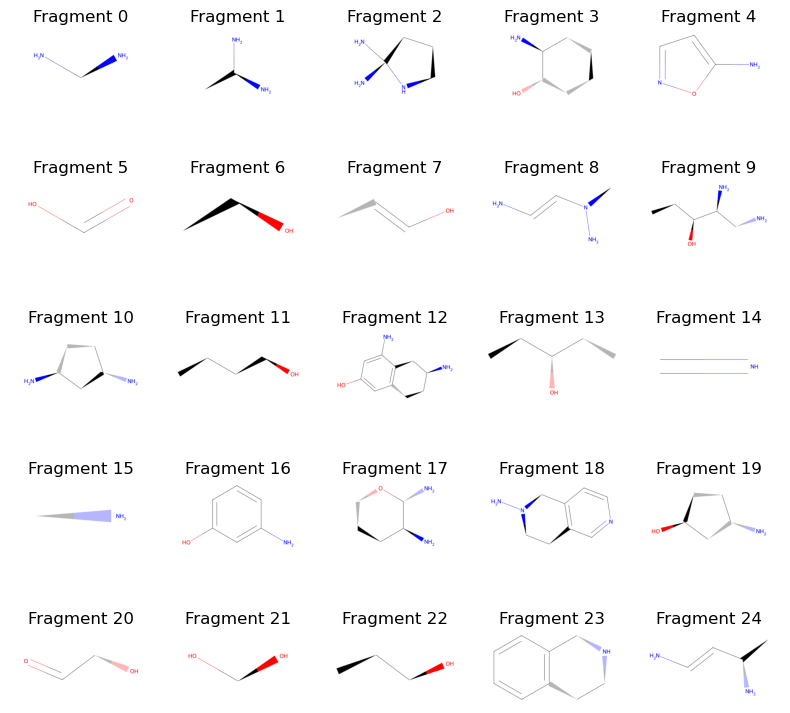

In [11]:
visualize_fragments(derivatives[:25], layout=(5,5), figsize=(8, 8))

That looks nice! And the only thing we did was use `random.choice` and `Molecule.change_element` in order to get here. We can now assemble the molecules into some format that is usable to us. For this example, let's simply assemble them into a new `PDBECompounds` instance and save them to a file so we can load them into future BuildAMol sessions more easily. 

In [12]:
# make a new compounds instance and add the fragments
compounds = bam.PDBECompounds(id="my_fragments")
for _mol in fragments + derivatives:
    # we autolabel the atoms so that we can easily identify them later on
    _mol.autolabel()
    compounds.add(_mol, type="fragment", identifiers=[_mol.id])

In [13]:
# now save to a file
compounds.to_json("./files/fragments.json")

And there we have it! Of course, if we are interested in using some deep learning techniques we would likely need to make a database with *RDKit* molecules instead of writing a BuildAMol JSON file. But that's easy as well. For instance, if the tool we want to work with accepts a pickle file containing a list of RDKit molecules we could generate this database using:

In [14]:
import pickle
with open("./files/rdkit_fragments.pkl", "wb") as f:
    rdkit_fragments = [i.to_rdkit() for i in fragments + derivatives]
    pickle.dump(rdkit_fragments, f)

And that's it for this tutorial! We have seen that making libraries of molecular fragments for deep learning purposes or other automatic frameworks can be a relatively straightforward process in BuildAMol. Of course, in this tutorial we used a small number of well defined fragmetns which we only slightly modified, so our use case was "well behaved". Still, with a bit of creativity you can adjust this example code to pretty much whatever your project requires. And with that, thanks for sticking with this tutorial all the way  an good luck with your research using BuildAMol! 